---
title: Dynamic Size DataLoader
from: markdown+emoji
author: "Dien-Hoa Truong"
date: 2023-02-04
categories: [deeplearning, timeseries]

---

Preparing the Dynamic size DataLoader for sequences with wide distributed length 

When you work with sequence data (sensors, music, ...), you might encounter a case when the sequence length distribution is very large. For example, a song can last 30s to many minutes. Resampling to fixed size can lose details information. In this blog post, I will talk about how to create a dynamic size `DataLoader`.

![DataLoader](https://visualstudiomagazine.com/-/media/ECG/visualstudiomagazine/Images/introimages/120731VSMCarrUpdateDelivery.jpg)

In [ ]:
from fastai.vision.all import *
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt

/home/hoa/miniconda3/envs/blog/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libc10_cuda.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


## Model works with Dynamic Size data

Below is some examples of layer/model which can deal with the dynamic size data. 

- `AdaptiveAvgPool` layer which is used widely in the `CNN` model
- `RNN` model

### AdaptiveAvgPool

[AdaptiveAvgPool2D](https://pytorch.org/docs/stable/generated/torch.nn.AdaptiveAvgPool2d.html) The output size is fixed no matter the input

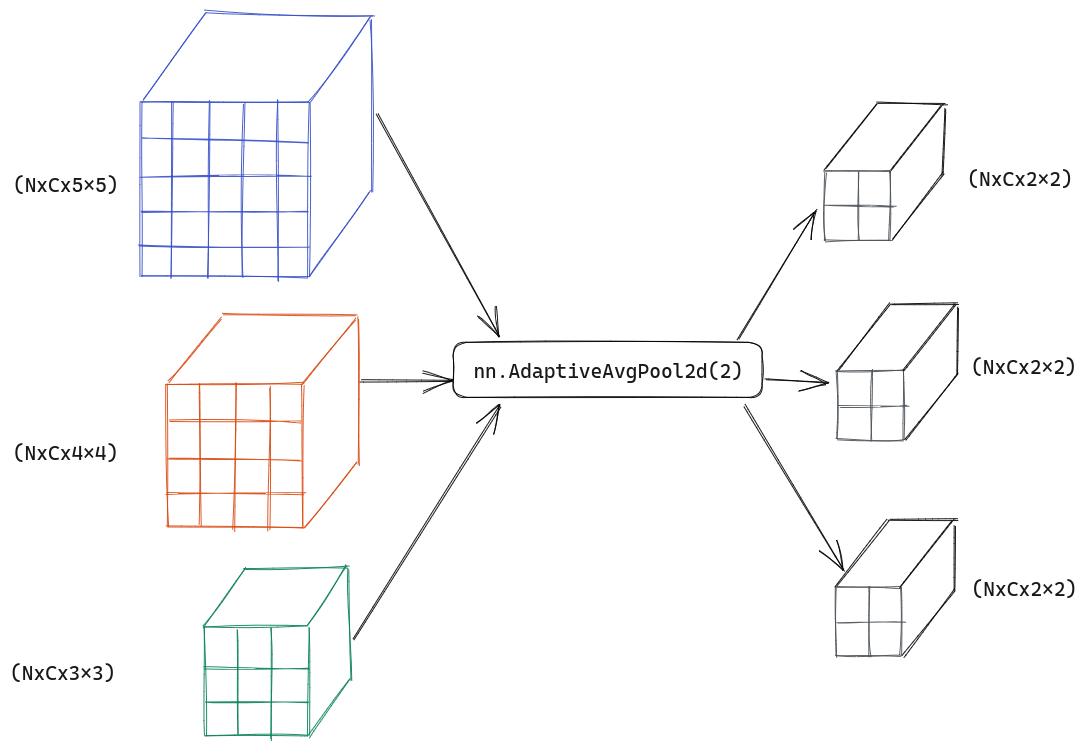

You can see below, no matter the input size ( [5,5], [6,4], [4,3] ), the output size is [2,2]

In [ ]:
x1 = torch.randn(8,16,5,5)
x2 = torch.randn(8,16,6,4)
x2 = torch.randn(8,16,4,3)

In [ ]:
nn.AdaptiveAvgPool2d(2)(x1).shape, nn.AdaptiveAvgPool2d(2)(x2).shape

(torch.Size([8, 16, 2, 2]), torch.Size([8, 16, 2, 2]))

### RNN

In a sequence classification problem, we can use a [RNN](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html) model, extracting the last timestep features and finally passing by a linear layer. So this kind of architecture doesn't depend on the input either.

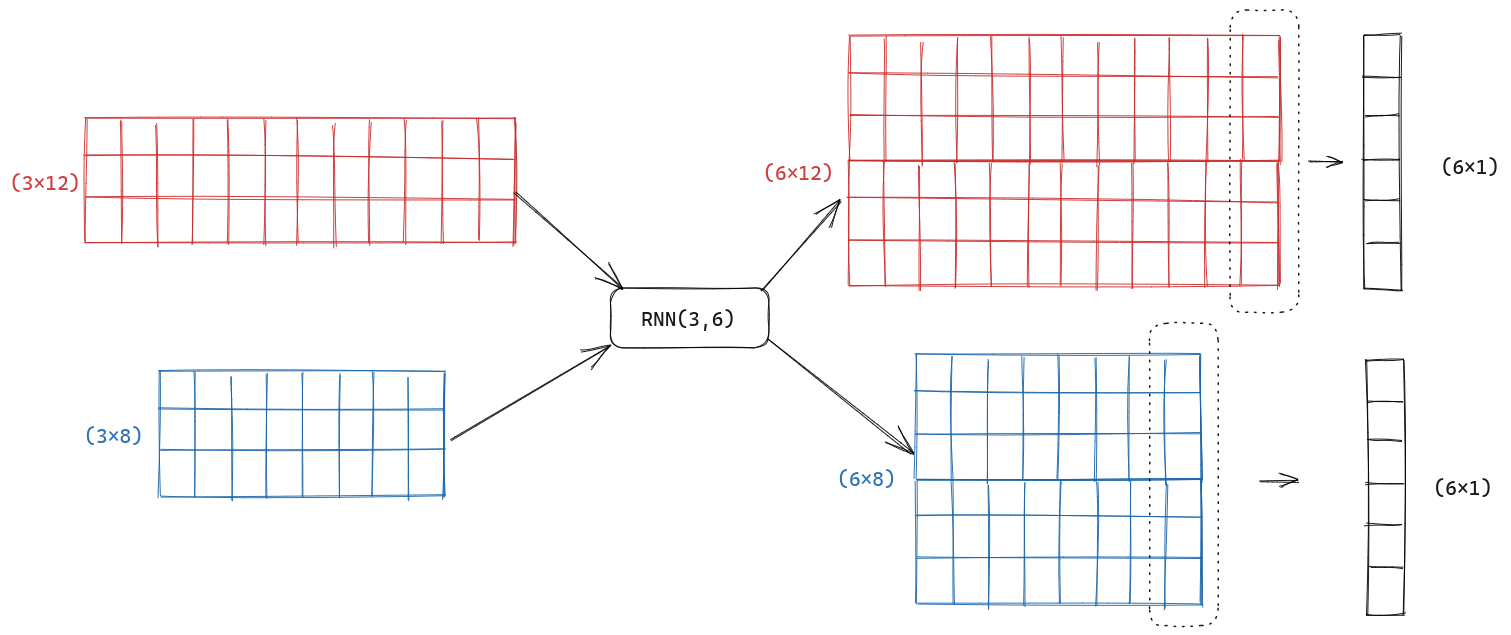

The inputs below are 3 features and 512-244 steps, after the `RNN` model, both outputs are [16,100]

In [ ]:
x1 = torch.randn(16, 512, 3)
x2 = torch.randn(16, 224, 3)

In [ ]:
rnn = nn.RNN(3,100)

In [ ]:
rnn(x1)[0].shape

torch.Size([16, 512, 100])

In [ ]:
rnn(x1)[0][:,-1].shape, rnn(x2)[0][:,-1].shape

(torch.Size([16, 100]), torch.Size([16, 100]))

There are many models like that in various libraries. For example: [timeseriesai](https://timeseriesai.github.io/tsai/). So the difficulty might not stay in building models but how to prepare the data to make use of their full power. Each problem is different so usually, you have to write the `DataLoader` yourself

Reference: Some codes are taken from @Ivan answer of the question [pytorch-can-i-group-batches-by-length](https://stackoverflow.com/questions/68782144/pytorch-can-i-group-batches-by-length) on stackoverflow

## Dynamic DataLoader

Let's first create a dataset where each item is a 1d series with different lengths

### Dataset

In [ ]:
class DS(Dataset):
    def __init__(self, signals):
        super().__init__()
        self.len = len(signals)
        self.signals = signals

    def __getitem__(self, i):
        return torch.tensor(self.signals[i]), torch.tensor([random.randint(0,1)])

    def __len__(self):
        return self.len

In [ ]:
signal_len = np.random.randint(0, 100, (16*6))
signals = [np.random.rand(s) for s in signal_len]
ds = DS(signals)

In [ ]:
signal_len

array([95, 77, 85, 87, 45, 47, 77, 93, 75,  2, 10, 69, 75, 61, 91, 13, 55,
       31,  3, 51, 68, 94, 28, 99, 93, 18, 48, 16, 81, 11, 74, 89, 36,  3,
       28, 92, 42, 36, 11, 44, 26, 63,  5,  4, 25, 54, 23, 23, 83, 33, 77,
       45, 38, 52, 50, 75, 17, 29,  2, 69, 44, 83,  1, 47, 12, 17, 14, 35,
       97, 53, 13, 49, 24, 78, 59,  1, 27, 43, 89, 37, 98,  8, 90, 77,  9,
       29, 46, 44, 10, 25, 35, 37, 49, 98, 17, 25])

### Collate Function

Even when you have a model that can handle input with different sizes, every item in a batch must have the same shape so they can be stacked together (the size of items in a batch are equal, but the sizes of different batches are different ). The `collate_fn` parameters in PyTorch [DataLoader](https://pytorch.org/docs/stable/data.html) is responsible for this job

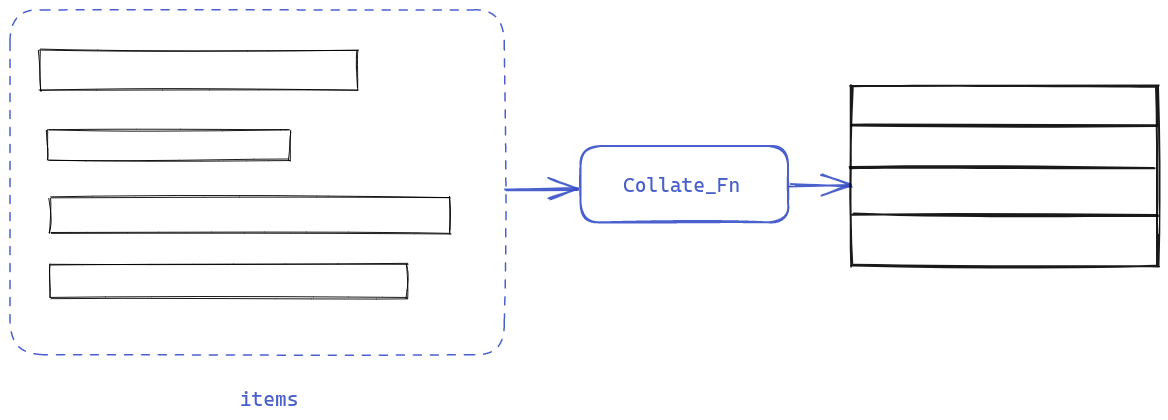

### Fixed Size DataLoader with interpolation

::: {.callout-note}
Before trying out Dynamic Size DataLoader, you should test the fixed sized first by using: [F.interpolate](https://pytorch.org/docs/stable/generated/torch.nn.functional.interpolate.html). It can be used as your baseline 
:::

Take a look at the x-axis in 2 plots below

In [ ]:
x = torch.sin(torch.arange(0,5,0.01))

[<matplotlib.lines.Line2D>]

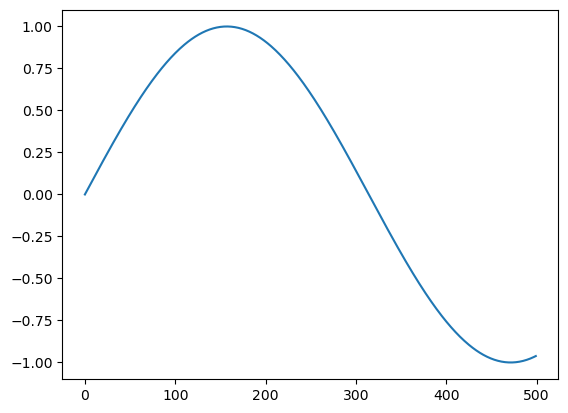

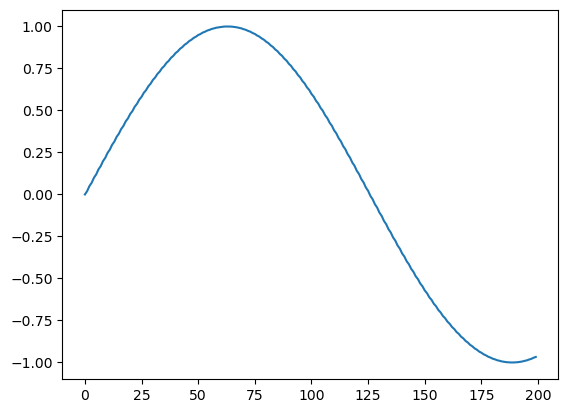

In [ ]:
plt.plot(x)
plt.figure()
plt.plot(np.array(F.interpolate(x[None,None,:], 200)[0].squeeze()))

Below is the simplest version of a `collate_fn` you should use in your baseline model

In [ ]:
batch = [ds[i] for i in range(4)]

::: {.callout-tip}
It's easier to write a function when you can experiment each line in a cell. I usually take out a list of item from the DataSet to experiment with my `collate_fn`. 
:::

In [ ]:
batch = [ds[i] for i in range(4)]

In [ ]:
def collate_fn(batch):
    (xx, yy) = zip(*batch)
    x_news = [F.interpolate(_x[None,None,:], (50))[0] for _x in xx]
    return torch.stack(x_news), torch.concat(yy)

In [ ]:
xb, yb = collate_fn(batch)

In [ ]:
xb.shape, yb.shape

(torch.Size([4, 1, 50]), torch.Size([4]))

Any item passed through this DataLoader will be rescaled to 50 timesteps. A disadvantage of this technique is that you will have distortion or you might lose details information.

### Dynamic size DataLoader

In this DataLoader, each batch will have a different size based on a reference (ex: maximum length of items). For padding, you can try padding with a constant, repeating signal, etc.

::: {.callout-cation}
the [F.pad](https://pytorch.org/docs/stable/generated/torch.nn.functional.pad.html) function in Pytorch can only work with `(padding value/2) < dimension`, so you might need to write the padding function yourself
:::

An example of padding is by repeating using [Tensor.repeat](https://pytorch.org/docs/stable/generated/torch.Tensor.repeat.html)

In [ ]:
x = torch.sin(torch.arange(0,5,0.01))

[<matplotlib.lines.Line2D>]

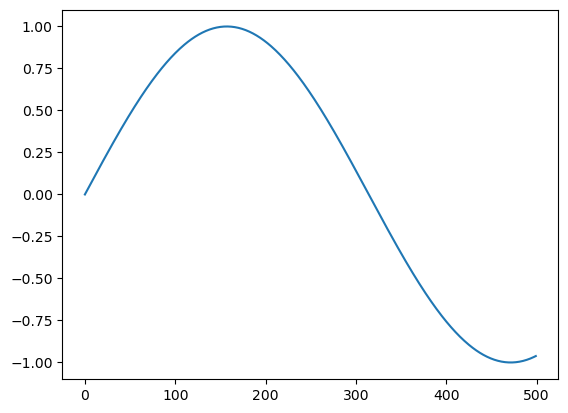

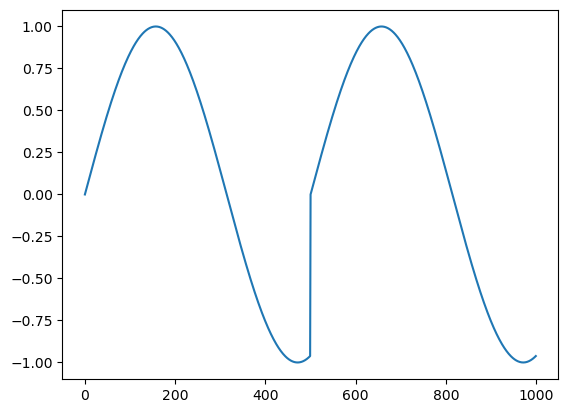

In [ ]:
plt.plot(x)
plt.figure()
plt.plot(x.repeat(2))

In [ ]:
def collate_padding(batch):
    (xx, yy) = zip(*batch)
    x_lens = [len(x) for x in xx]
    idx_max = np.argmax(x_lens)
    max_len = x_lens[idx_max]
    
    x_pads = []
    for i, _x in enumerate(xx):
        if i == idx_max:
            x_pad = _x
        else:
            pad_nb = max_len//_x.shape[0]
            x_pad = _x.repeat(1+pad_nb)[:max_len]
        x_pads.append(x_pad)
    return torch.stack(x_pads), torch.concat(yy)

In [ ]:
xb, yb = collate_padding(batch)

In [ ]:
xb.shape, yb.shape

(torch.Size([4, 95]), torch.Size([4]))

In [ ]:
dl = DataLoader(dataset=ds, batch_size=16, shuffle=True, collate_fn=collate_padding)

In [ ]:
for x in dl:
    print(x[0].shape)

torch.Size([16, 93])
torch.Size([16, 98])
torch.Size([16, 99])
torch.Size([16, 97])
torch.Size([16, 94])
torch.Size([16, 74])


### Grouping batch by size

In the padding collate_fn version above, in a batch, if you have one very short item and one is very long, the short one will be repeated again and again and it is irrealistic in the real case (You can see the `signal_len` is distributed from 1 to 100 but most of the batches above are long). So you might want to group each batch based on their sizes

In [ ]:
signal_len

array([95, 77, 85, 87, 45, 47, 77, 93, 75,  2, 10, 69, 75, 61, 91, 13, 55,
       31,  3, 51, 68, 94, 28, 99, 93, 18, 48, 16, 81, 11, 74, 89, 36,  3,
       28, 92, 42, 36, 11, 44, 26, 63,  5,  4, 25, 54, 23, 23, 83, 33, 77,
       45, 38, 52, 50, 75, 17, 29,  2, 69, 44, 83,  1, 47, 12, 17, 14, 35,
       97, 53, 13, 49, 24, 78, 59,  1, 27, 43, 89, 37, 98,  8, 90, 77,  9,
       29, 46, 44, 10, 25, 35, 37, 49, 98, 17, 25])

How do you do that? by using the `batch_sampler` parameter in [DataLoader](https://pytorch.org/docs/stable/data.html). Now it's you to control which item in the `Dataset` is passed through which iteration in the `DataLoader`

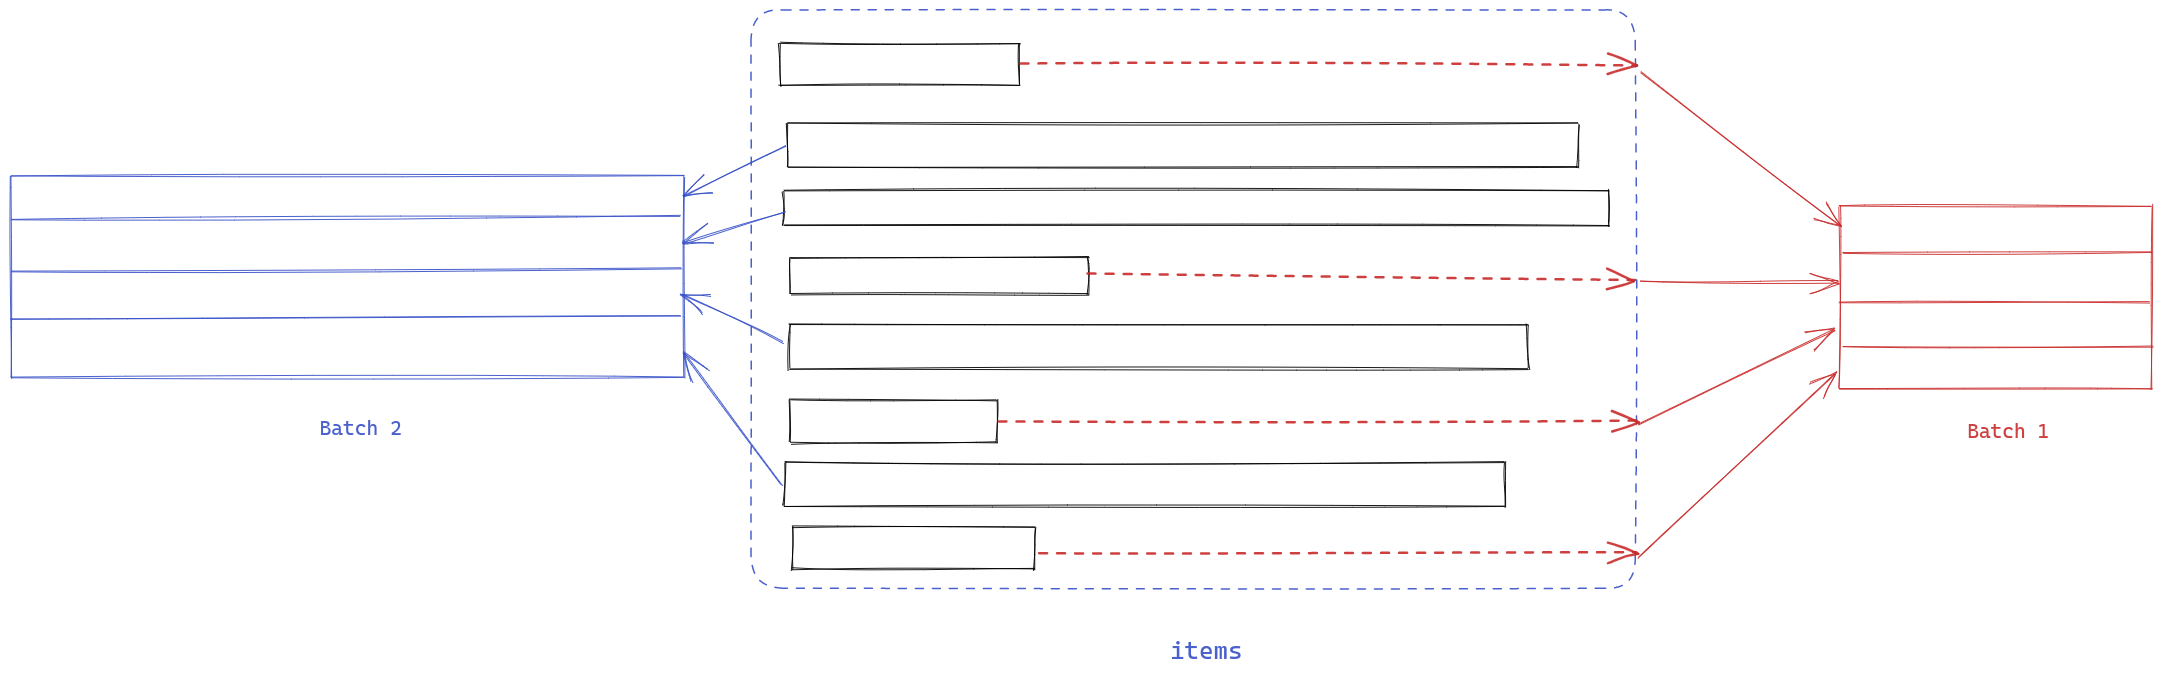

In [ ]:
batch_nb = 6

In [ ]:
sampler = np.split(signal_len.argsort()[::-1], batch_nb)

In [ ]:
dl = DataLoader(dataset=ds, batch_sampler=sampler, collate_fn=collate_padding)

In [ ]:
batches

[array([23, 80, 93, 68,  0, 21, 24,  7, 35, 14, 82, 78, 31,  3,  2, 61]),
 array([48, 28, 73,  1, 50,  6, 83, 55, 12,  8, 30, 59, 11, 20, 41, 13]),
 array([74, 16, 45, 69, 53, 19, 54, 92, 71, 26,  5, 63, 86, 51,  4, 60]),
 array([39, 87, 77, 36, 52, 79, 91, 32, 37, 67, 90, 49, 17, 85, 57, 34]),
 array([22, 76, 40, 95, 89, 44, 72, 47, 46, 25, 94, 65, 56, 27, 66, 15]),
 array([70, 64, 29, 38, 10, 88, 84, 81, 42, 43, 33, 18,  9, 58, 75, 62])]

In [ ]:
for x in dl:
    print(x[0].shape)

torch.Size([16, 99])
torch.Size([16, 83])
torch.Size([16, 59])
torch.Size([16, 44])
torch.Size([16, 28])
torch.Size([16, 13])


From the shape above, you can see that the size's length is distributed better in each batch.

::: {.callout-note}
Now, items in each batch don't change, so you might lose the randomness in your training process which might lead to an overfit -> Use with caution
:::